In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import random
import timm
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from transformers import BertModel, BertTokenizer
from transformers import XLNetModel, XLNetTokenizer
from transformers import BertForSequenceClassification, XLNetForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [37]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(50)

In [38]:
# import re
# import nltk
# from nltk.corpus import stopwords

# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = ' '.join([word for word in text.split() if word not in stop_words])
#     return text

# def merge_tags(tags):
#     if tags is None:
#         return ''
#     return ' '.join(tags)

def preprocess_data(data):
    data = data.fillna('.')
#     data['title'] = data['title'].apply(preprocess_text)
#     data['description'] = data['description'].apply(preprocess_text)
#     data['user_tags'] = data['user_tags'].apply(merge_tags).apply(preprocess_text)
    return data




In [39]:
# def remove_brackets(text):
#     if isinstance(text, list):
#         text = ', '.join(text)
#     return text

In [40]:
import json

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data['images'])

train_df = read_json('/kaggle/input/dataset/devset_images_metadata.json')
TRAIN_LABEL_PATH = '/kaggle/input/dataset/devset_images_gt.csv'
label_csv = pd.read_csv(TRAIN_LABEL_PATH)
label_csv = label_csv.rename(columns={'id': 'image_id'})
train_df['image_id'] = train_df['image_id'].astype(int)
train_df = train_df.merge(label_csv, on='image_id', how='inner')
train_df = train_df.drop(['license_name', 'user_nsid', 'image_extension_original', 'longitude','license_url','date_uploaded','date_taken','latitude','image_url','capture_device','user_nickname'], axis=1)


In [41]:
train_df

,description,user_tags,title,image_id,label
0,None,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,None,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,None,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,None,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,None,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,None,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,None,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [42]:

# train_df['user_tags'] = train_df['user_tags'].apply(remove_brackets)


In [43]:
train_df 

,description,user_tags,title,image_id,label
0,None,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,None,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,None,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,None,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,None,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,None,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,None,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [44]:
train_df = preprocess_data(train_df)


In [45]:
train_df

,description,user_tags,title,image_id,label
0,.,"[2009 road trip, obrero road trip]",Biltmore Estate,3519864665,0
1,.,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,4896119055,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,3468473862,0
3,.,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,4120853942,0
4,.,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,4436083254,0
...,...,...,...,...,...
5275,.,"[550d, camino, canon, canoneos550d, canoneoski...",90,8119782888,0
5276,.,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",6093294301,1
5277,.,"[al, the waters in pike road]",IMG_4989,6791185487,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,9144682941,0


In [46]:
import glob
train_images = glob.glob('/kaggle/input/dataset/devset_images/devset_images/*')
train_images[:5]

['/kaggle/input/dataset/devset_images/devset_images/6099582129.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/2481944299.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/6820987318.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/864584409.jpg',
 '/kaggle/input/dataset/devset_images/devset_images/9349393459.jpg']

In [47]:
images_path = "/kaggle/input/dataset/devset_images/devset_images"


In [48]:
# train_df.to_csv('train_df.csv', index=False)

In [49]:
image_ids = [int(fp.split('/')[-1].split('.')[0]) for fp in train_images]

mapping = dict(zip(image_ids, train_images))

train_df['image_id'] = train_df['image_id'].map(mapping)

train_df

,description,user_tags,title,image_id,label
0,.,"[2009 road trip, obrero road trip]",Biltmore Estate,/kaggle/input/dataset/devset_images/devset_ima...,0
1,.,"[daulatabad, daulatabad fort, ellora, road trip]",Chand Minar,/kaggle/input/dataset/devset_images/devset_ima...,0
2,"After the flood, the boarded up stores bear up...","[cedarrapids, createsouthroadtrip2009, disaste...",Uplifting Graffiti,/kaggle/input/dataset/devset_images/devset_ima...,0
3,.,"[cork, enchente, flood, ireland, irlanda]",DSCF6487,/kaggle/input/dataset/devset_images/devset_ima...,0
4,.,"[athens georgia, brown, current, flood, mud, r...",Oconoe river - flooded,/kaggle/input/dataset/devset_images/devset_ima...,0
...,...,...,...,...,...
5275,.,"[550d, camino, canon, canoneos550d, canoneoski...",90,/kaggle/input/dataset/devset_images/devset_ima...,0
5276,.,"[albany, ny, flood, walk, water]","Albany's Corning Preserve, day after Irene",/kaggle/input/dataset/devset_images/devset_ima...,1
5277,.,"[al, the waters in pike road]",IMG_4989,/kaggle/input/dataset/devset_images/devset_ima...,0
5278,2013 Fair Flood,"[2013, county, fair, flood, linn]",IMG_3011,/kaggle/input/dataset/devset_images/devset_ima...,0


In [50]:
print(len(train_df))


5280


In [51]:
validdf= train_df[:528]

traindf= train_df[528:]

In [52]:
print(len(traindf))
print(len(validdf))

4752
528


In [53]:
transform_train = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [54]:
momentum = 0.9
beta_2 = 0.999
epsilon = None
weight_decay = 0.0
amsgrad = False

In [55]:
def callbacks_check(model_name):
    num_classes = 2
    accuracy_threshold = 0.99

    class MyCallback:
        def __init__(self):
            self.best_accuracy = 0.0

        def on_epoch_end(self, epoch, accuracy):
            if accuracy > accuracy_threshold:
                print("\nReached {:.2f}% accuracy, so we will stop training".format(accuracy_threshold * 100))
                return True
            return False

    acc_callback = MyCallback()
    
    return acc_callback

In [56]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomCombinedDataset(Dataset):
    def __init__(self, dataframe, images_path, tokenizer, max_length, transforms=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # Fetch image
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image_id'])
        image = Image.open(img_name)
        
        if self.transforms:
            image = self.transforms(image)


        # Fetch text fields and label
        description = str(self.dataframe.iloc[index]['description'])
        user_tags = str(self.dataframe.iloc[index]['user_tags'])
        label = self.dataframe.iloc[index]['label']
        title = str(self.dataframe.iloc[index]['title'])
        # Combine description and user_tags
        combined_text = description + " " + user_tags + " " + title

        # Tokenize combined text
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            padding='max_length'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [57]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length= 300

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [58]:
combined_train_dataset = CustomCombinedDataset(traindf, images_path, tokenizer, max_length, transforms=transform_train)
combined_valid_dataset = CustomCombinedDataset(validdf, images_path, tokenizer, max_length, transforms=transform_test)

In [59]:
len(combined_train_dataset)

4752

In [60]:
criterion = nn.CrossEntropyLoss()
num_classes = 2
batch_size = 12
num_iters= 30000
num_epochs = num_iters / (len(combined_train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

75


In [61]:
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
combined_valid_loader = DataLoader(combined_valid_dataset, batch_size=batch_size, shuffle=False)

In [62]:
len(combined_train_loader)


396

In [63]:
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        
#         # Image Model (ResNet-50)
#         self.image_model = models.resnet50(pretrained=True)   
#         num_image_features = self.image_model.fc.in_features
#         self.image_model.fc = nn.Sequential(
#             nn.Linear(num_image_features, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate)
#         )

#         self.image_model = models.densenet201(pretrained=True)
#         torch.nn.Sequential(*list(self.image_model.children())[:-1])
#         num_features = self.image_model.classifier.in_features
#         self.image_model.classifier = nn.Sequential(
#             nn.Linear(num_features, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate)
#         )
       
        self.image_model = EfficientNet.from_pretrained('efficientnet-b3')
        torch.nn.Sequential(*list(self.image_model.children())[:-1])
        num_features = self.image_model._fc.in_features
        self.image_model._fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        
        # Text Model (BERT)
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_linear = nn.Linear(self.text_model.config.hidden_size, 512)
        
        # Fusion Layer
        self.fusion_linear = nn.Linear(1024, num_classes)
    
    def forward(self, image_input, text_input_ids, text_attention_mask):
        # Process image
        image_features = self.image_model(image_input)
        
        # Process text
        text_outputs = self.text_model(text_input_ids, attention_mask=text_attention_mask)
        pooled_text_output = text_outputs.pooler_output
        text_features = self.text_linear(pooled_text_output)
        
        # Concatenate image and text features
        multimodal_features = torch.cat((image_features, text_features), dim=1)
        
        # Fusion layer
        combined_logits = self.fusion_linear(multimodal_features)
        
        return combined_logits

In [64]:
num_classes = 2
dropout_rate= 0.2

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [66]:
combined_model = MultimodalClassifier()
combined_model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 269MB/s]


Loaded pretrained weights for efficientnet-b3


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

MultimodalClassifier(
  (image_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dSt

In [67]:
optimizer = optim.Adam(combined_model.parameters(), lr= 0.0000001)
criterion = nn.CrossEntropyLoss()

In [68]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [69]:
patience = 15
best_val_loss = float('inf')
counter = 0

callback_list = callbacks_check(combined_model)

for epoch in range(num_epochs):
    combined_model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    
    for batch_idx, batch_data in enumerate(combined_train_loader):
        
        images = batch_data['image'].to(device)
        input_ids = batch_data['input_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        labels = batch_data['label'].to(device)
        
        img_output = combined_model(images, input_ids, attention_mask)
        
        loss = criterion(img_output, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(img_output, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = total_loss / len(combined_train_loader)
    epoch_accuracy = correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')
    
    combined_model.eval()
    valid_correct = 0
    valid_total_samples = 0
    valid_loss = 0.0
    
    with torch.no_grad():
        for valid_batch_data in combined_valid_loader:
            valid_images = valid_batch_data['image'].to(device)
            valid_input_ids = valid_batch_data['input_ids'].to(device)
            valid_attention_mask = valid_batch_data['attention_mask'].to(device)
            valid_labels = valid_batch_data['label'].to(device)
            
            valid_output = combined_model(valid_images, valid_input_ids, valid_attention_mask)
            valid_loss += criterion(valid_output, valid_labels).item()
            
            _, valid_predicted = torch.max(valid_output, 1)
            valid_correct += (valid_predicted == valid_labels).sum().item()
            valid_total_samples += valid_labels.size(0)
            
    valid_epoch_loss = valid_loss / len(combined_valid_loader)
    valid_epoch_accuracy = valid_correct / valid_total_samples
    valid_losses.append(valid_epoch_loss)
    valid_accuracies.append(valid_epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {valid_epoch_loss:.4f}, Validation Accuracy: {valid_epoch_accuracy:.4f}')
    
    if callback_list.on_epoch_end(epoch+1,epoch_accuracy):
            print(print("Early stopping triggered at epoch",epoch+1))
            break
            
    elif (valid_epoch_loss < best_val_loss):
            best_val_loss = valid_epoch_loss
            counter = 0
            torch.save(combined_model.state_dict(),'best_model.pt')
            print("Combine Model saved")
            combined_model.train()
            
    else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}.')
                break
torch.save(combined_model.state_dict(), 'Combine_last_model.pt')
print("Combine Last Model saved")

Epoch [1/75], Train Loss: 0.6740, Train Accuracy: 0.5657
Epoch [1/75], Validation Loss: 0.6401, Validation Accuracy: 0.6572
Combine Model saved
Epoch [2/75], Train Loss: 0.6305, Train Accuracy: 0.6347
Epoch [2/75], Validation Loss: 0.5837, Validation Accuracy: 0.6686
Combine Model saved
Epoch [3/75], Train Loss: 0.5189, Train Accuracy: 0.7973
Epoch [3/75], Validation Loss: 0.4446, Validation Accuracy: 0.8295
Combine Model saved
Epoch [4/75], Train Loss: 0.3732, Train Accuracy: 0.8716
Epoch [4/75], Validation Loss: 0.3909, Validation Accuracy: 0.8371
Combine Model saved
Epoch [5/75], Train Loss: 0.3127, Train Accuracy: 0.8847
Epoch [5/75], Validation Loss: 0.3587, Validation Accuracy: 0.8542
Combine Model saved
Epoch [6/75], Train Loss: 0.2744, Train Accuracy: 0.8958
Epoch [6/75], Validation Loss: 0.3454, Validation Accuracy: 0.8580
Combine Model saved
Epoch [7/75], Train Loss: 0.2406, Train Accuracy: 0.9078
Epoch [7/75], Validation Loss: 0.3221, Validation Accuracy: 0.8561
Combine Mode

In [76]:
import torch
from sklearn.metrics import classification_report

best_model_path = 'best_model.pt'
combined_model.load_state_dict(torch.load(best_model_path))
combined_model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for valid_batch_data in combined_valid_loader:
        valid_images = valid_batch_data['image'].to(device)
        valid_input_ids = valid_batch_data['input_ids'].to(device)
        valid_attention_mask = valid_batch_data['attention_mask'].to(device)
        valid_labels = valid_batch_data['label'].to(device)
        
        valid_output = combined_model(valid_images, valid_input_ids, valid_attention_mask)
        
        _, valid_predicted = torch.max(valid_output, 1)
        
        all_labels.extend(valid_labels.cpu().numpy())
        all_predictions.extend(valid_predicted.cpu().numpy())

target_names = [
    'non_flood', 'flood'
]
unique_labels = sorted(set(all_labels))

report = classification_report(all_labels, all_predictions, labels=unique_labels, target_names=target_names)

print(report)


              precision    recall  f1-score   support

   non_flood       0.96      0.88      0.92       347
       flood       0.80      0.93      0.86       181

    accuracy                           0.90       528
   macro avg       0.88      0.90      0.89       528
weighted avg       0.91      0.90      0.90       528



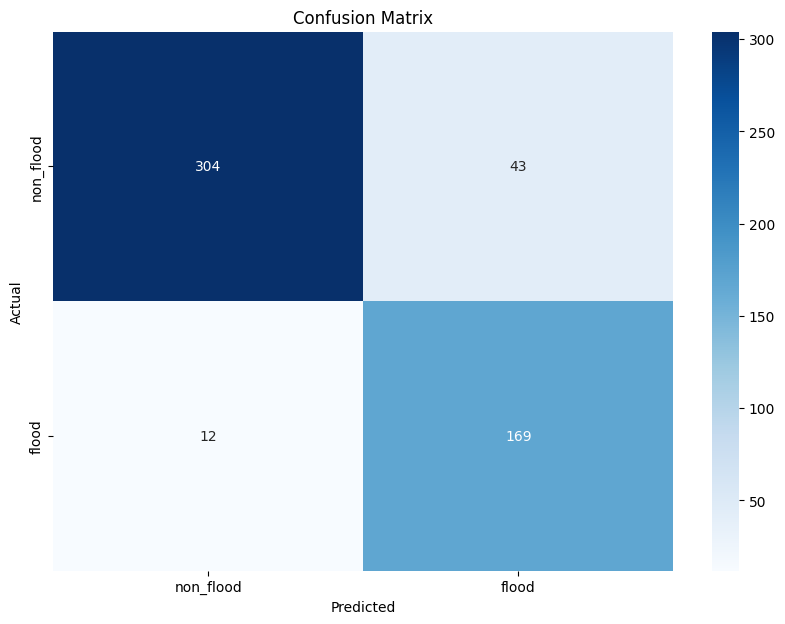

In [78]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=unique_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Train & Validation Accuracy')

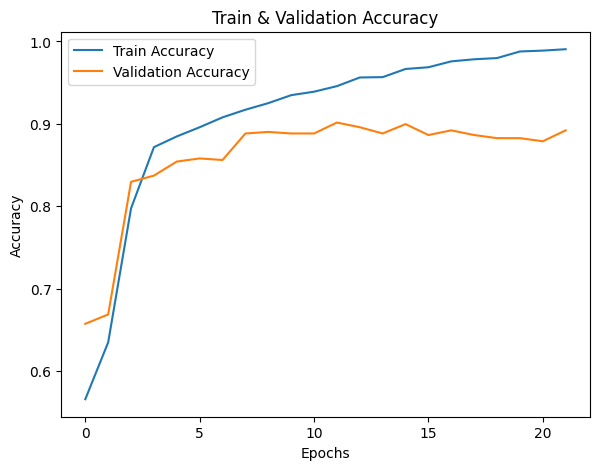

In [79]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

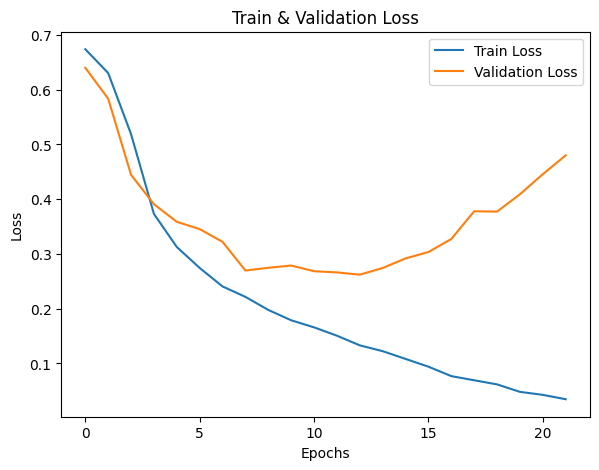

In [80]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')
plt.show()

In [ ]:
combined_model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
print('Model Loaded')

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, dataframe, images_path, tokenizer, max_length, transforms=None, has_labels=True):
        self.dataframe = dataframe
        self.images_path = images_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transforms = transforms
    

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image_id'])
        image = Image.open(img_name)
        
        if self.transforms:
            image = self.transforms(image)

        description = str(self.dataframe.iloc[index]['description'])
        user_tags = str(self.dataframe.iloc[index]['user_tags'])
        title = str(self.dataframe.iloc[index]['title'])
        combined_text = description + " " + user_tags + " " + title

        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            padding='max_length'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Get image_id to associate with predictions
        image_id = self.dataframe.iloc[index]['image_id']

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image_id': image_id
        }



In [ ]:
test_csv_path = '/kaggle/input/dataset/test.csv'
test_df = pd.read_csv(test_csv_path)

In [ ]:
test_images = glob.glob('/kaggle/input/dataset/testset_images/testset_images/*')
test_images[:5]

In [ ]:
image_test_ids = [int(fp.split('/')[-1].split('.')[0]) for fp in test_images]

mapping = dict(zip(image_test_ids, test_images))


test_df['image_id'] = test_df['image_id'].map(mapping)

test_df


In [ ]:
def add_brackets(text):
    return f'[{text}]'

In [ ]:
test_df['user_tags'] = test_df['user_tags'].apply(add_brackets)

In [ ]:
test_df = preprocess_data(test_df)

In [ ]:
test_df


In [ ]:
test_df = CustomTestDataset(test_df, images_path, tokenizer, max_length, transforms=transform_test)


In [ ]:
combined_test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)


In [ ]:
ctest_predicted_lst = []
ctest_ids_lst = []  

with torch.no_grad():
    for ctest_batch_data in combined_test_loader:
        ctest_images = ctest_batch_data['image'].to(device)
        ctest_input_ids = ctest_batch_data['input_ids'].to(device)
        ctest_attention_mask = ctest_batch_data['attention_mask'].to(device)
        ctest_batch_ids = ctest_batch_data['image_id']
        
        ctest_output = combined_model(ctest_images, ctest_input_ids, ctest_attention_mask)
        
        _, ctest_predicted = torch.max(ctest_output, 1)
        
        ctest_predicted_lst.extend(ctest_predicted.cpu().numpy())
        
        ctest_ids_lst.extend(ctest_batch_ids)

In [ ]:
image_ids = []
for file_path in ctest_ids_lst:
    filename = os.path.basename(file_path)
    image_id = os.path.splitext(filename)[0]
    image_ids.append(image_id)
    
print(image_ids[:5])


In [ ]:
results_df = pd.DataFrame({
    'id': image_ids,
    'label': ctest_predicted_lst
})

results_df.to_csv('predictions.csv', index=False)